In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0207

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.0142
Average validation loss: 0.5691329836845398
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - loss: 0.0142 - val_loss: 0.5691
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - loss: 0.0090 - val_loss: 0.5691
Average validation loss: 0.37784555554389954
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - loss: 0.0090 - val_loss: 0.4735
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - loss: 0.0064 - val_loss: 0.4735
Average validation loss: 0.3934973478317261
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - loss: 0.0064 - val_loss: 0.4468
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - loss: 0.0050 - val_loss: 0.4468
Average validation loss: 0.254

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 945ms/step - loss: 6.8158e-07
Average validation loss: 0.08992289938032627
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 954ms/step - loss: 6.8158e-07 - val_loss: 0.0899
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 909ms/step - loss: 5.7703e-07 - val_loss: 0.0899
Average validation loss: 0.10712027922272682
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - loss: 5.7703e-07 - val_loss: 0.0985
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 929ms/step - loss: 5.3147e-07 - val_loss: 0.0985
Average validation loss: 0.0780283473432064
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 938ms/step - loss: 5.3147e-07 - val_loss: 0.0917
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 917ms/step - loss: 5.0372e-07 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 933ms/step - loss: 2.0313e-07
Average validation loss: 0.03647570932904879
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 961ms/step - loss: 2.0313e-07 - val_loss: 0.0365
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 954ms/step - loss: 1.9188e-07 - val_loss: 0.0365
Average validation loss: 0.05024144550164541
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 965ms/step - loss: 1.9188e-07 - val_loss: 0.0434
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 901ms/step - loss: 1.8528e-07 - val_loss: 0.0434
Average validation loss: 0.04225226491689682
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 927ms/step - loss: 1.8528e-07 - val_loss: 0.0430
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 953ms/step - loss: 1.8117e-07 - val_loss: 0.0430
Average validation loss: 0.06422110212345918
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 967ms/step - loss: 1.8117e-07 - val_loss: 0.0483
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 950ms/step - loss: 1.1767e-07
Average validation loss: 0.039588557090610266
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 961ms/step - loss: 1.1767e-07 - val_loss: 0.0396
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 972ms/step - loss: 1.1805e-07 - val_loss: 0.0396
Average validation loss: 0.03221149276942015
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 994ms/step - loss: 1.1805e-07 - val_loss: 0.0359
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 940ms/step - loss: 1.1781e-07 - val_loss: 0.0359
Average validation loss: 0.03733672900125384
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 956ms/step - loss: 1.1781e-07 - val_loss: 0.0364
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 930ms/step - loss: 1.1677

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 927ms/step - loss: 1.1336e-07
Average validation loss: 0.031250625662505624
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 938ms/step - loss: 1.1336e-07 - val_loss: 0.0313
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 942ms/step - loss: 1.0504e-07 - val_loss: 0.0313
Average validation loss: 0.02493495065718889
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 962ms/step - loss: 1.0504e-07 - val_loss: 0.0281
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 925ms/step - loss: 9.7186e-08 - val_loss: 0.0281
Average validation loss: 0.028975335229188205
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 936ms/step - loss: 9.7186e-08 - val_loss: 0.0284
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 947ms/step - loss: 9.344

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 933ms/step - loss: 1.3099e-07
Average validation loss: 0.026309511081005137
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 951ms/step - loss: 1.3099e-07 - val_loss: 0.0263
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 929ms/step - loss: 1.2968e-07 - val_loss: 0.0263
Average validation loss: 0.018975822914702196
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 949ms/step - loss: 1.2968e-07 - val_loss: 0.0226
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 939ms/step - loss: 1.3620e-07 - val_loss: 0.0226
Average validation loss: 0.02082644139106075
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 950ms/step - loss: 1.3620e-07 - val_loss: 0.0220
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 925ms/step - loss: 1.246

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 934ms/step - loss: 1.4480e-07
Average validation loss: 0.03740952825173736
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 952ms/step - loss: 1.4480e-07 - val_loss: 0.0374
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 935ms/step - loss: 1.2118e-07 - val_loss: 0.0374
Average validation loss: 0.04947148435749114
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 949ms/step - loss: 1.2118e-07 - val_loss: 0.0434
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 933ms/step - loss: 1.0996e-07 - val_loss: 0.0434
Average validation loss: 0.04641528152860701
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 947ms/step - loss: 1.0996e-07 - val_loss: 0.0444
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 932ms/step - loss: 1.0501e-07 - val_loss: 0.0444
Average validation loss: 0.04886101596057415
40/40 ━━━━━━━━━━━━━━━━━━━━ 152s 947ms/step - loss: 1.0501e-07 - val_loss: 0.0455
Epoch

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 924ms/step - loss: 1.3301e-07
Average validation loss: 0.02344715529276679
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 933ms/step - loss: 1.3301e-07 - val_loss: 0.0234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 952ms/step - loss: 1.2796e-07 - val_loss: 0.0234
Average validation loss: 0.022970159421674907
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 965ms/step - loss: 1.2796e-07 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 136s 942ms/step - loss: 1.1845e-07 - val_loss: 0.0232
Average validation loss: 0.022124694117034476
48/48 ━━━━━━━━━━━━━━━━━━━━ 137s 955ms/step - loss: 1.1845e-07 - val_loss: 0.0228
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 928ms/step - loss: 9.2899e-08
Average validation loss: 0.020511512511542866
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 944ms/step - loss: 9.2899e-08 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 927ms/step - loss: 8.5523e-08 - val_loss: 0.0205
Average validation loss: 0.020684588634009873
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 940ms/step - loss: 8.5523e-08 - val_loss: 0.0206
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 927ms/step - loss: 7.8556e-08 - val_loss: 0.0206
Average validation loss: 0.018758321979216168
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 943ms/step - loss: 7.8556e-08 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 210s 930ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 920ms/step - loss: 7.3043e-08
Average validation loss: 0.018440409301547334
64/64 ━━━━━━━━━━━━━━━━━━━━ 60s 933ms/step - loss: 7.3043e-08 - val_loss: 0.0184
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 929ms/step - loss: 6.2051e-08 - val_loss: 0.0184
Average validation loss: 0.01391391598735936
64/64 ━━━━━━━━━━━━━━━━━━━━ 120s 944ms/step - loss: 6.2051e-08 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 927ms/step - loss: 5.6916e-08 - val_loss: 0.0162
Average validation loss: 0.017400610755430534
64/64 ━━━━━━━━━━━━━━━━━━━━ 180s 943ms/step - loss: 5.6916e-08 - val_loss: 0.0166
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 240s 929ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 930ms/step - loss: 1.1919e-07
Average validation loss: 0.023288338729697797
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 946ms/step - loss: 1.1919e-07 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 134s 917ms/step - loss: 1.2360e-07 - val_loss: 0.0233
Average validation loss: 0.02481350561396943
72/72 ━━━━━━━━━━━━━━━━━━━━ 135s 932ms/step - loss: 1.2360e-07 - val_loss: 0.0241
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 203s 931ms/step - loss: 1.0603e-07 - val_loss: 0.0241
Average validation loss: 0.02406005232801868
72/72 ━━━━━━━━━━━━━━━━━━━━ 204s 946ms/step - loss: 1.0603e-07 - val_loss: 0.0241
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 270s 925ms/step - loss: 9.3563e-08 - val_loss: 0.0241
Average validation loss: 0.024029071753223736
72/72 ━━━━━━━━━━━━━━━━━━━━ 271s 940ms/step - loss: 9.3563e-08 - val_loss: 0.0240
E

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 940ms/step - loss: 3.3330e-07
Average validation loss: 0.0341356816701591
80/80 ━━━━━━━━━━━━━━━━━━━━ 76s 957ms/step - loss: 3.3330e-07 - val_loss: 0.0341
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 944ms/step - loss: 3.0457e-07 - val_loss: 0.0341
Average validation loss: 0.01725050595123321
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 958ms/step - loss: 3.0457e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 228s 929ms/step - loss: 2.9669e-07 - val_loss: 0.0257
Average validation loss: 0.017434956133365632
80/80 ━━━━━━━━━━━━━━━━━━━━ 229s 944ms/step - loss: 2.9669e-07 - val_loss: 0.0229
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 304s 935ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 937ms/step - loss: 2.1842e-07
Average validation loss: 0.02353669045260176
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 953ms/step - loss: 2.1842e-07 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 181s 937ms/step - loss: 1.8348e-07 - val_loss: 0.0235
Average validation loss: 0.02280048669005434
96/96 ━━━━━━━━━━━━━━━━━━━━ 183s 953ms/step - loss: 1.8348e-07 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 273s 942ms/step - loss: 1.5491e-07 - val_loss: 0.0232
Average validation loss: 0.02148795952477182
96/96 ━━━━━━━━━━━━━━━━━━━━ 275s 957ms/step - loss: 1.5491e-07 - val_loss: 0.0226
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 112s 933ms/step - loss: 4.3815e-07
Average validation loss: 0.028898021737889697
120/120 ━━━━━━━━━━━━━━━━━━━━ 114s 947ms/step - loss: 4.3815e-07 - val_loss: 0.0289
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 225s 932ms/step - loss: 3.7434e-07 - val_loss: 0.0289
Average validation loss: 0.019424487619350353
120/120 ━━━━━━━━━━━━━━━━━━━━ 227s 947ms/step - loss: 3.7434e-07 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 340s 945ms/step - loss: 2.8549e-07 - val_loss: 0.0242
Average validation loss: 0.012072796809176604
120/120 ━━━━━━━━━━━━━━━━━━━━ 342s 960ms/step - loss: 2.8549e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\Rip

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 775ms/step - loss: 7.9257e-08
Average validation loss: 0.015214035368343402
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 7.9257e-08 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 780ms/step - loss: 7.3056e-08 - val_loss: 0.0152
Average validation loss: 0.014301903432674913
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 791ms/step - loss: 7.3056e-08 - val_loss: 0.0148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 344s 808ms/step - loss: 6.6130e-08 - val_loss: 0.0148
Average validation loss: 0.016271801589431964
144/144 ━━━━━━━━━━━━━━━━━━━━ 345s 818ms/step - loss: 6.6130e-08 - val_loss: 0.0153
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 456s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 772ms/step - loss: 6.0555e-08
Average validation loss: 0.01626161189378763
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 783ms/step - loss: 6.0555e-08 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 248s 766ms/step - loss: 4.8971e-08 - val_loss: 0.0163
Average validation loss: 0.014636884403444128
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 777ms/step - loss: 4.8971e-08 - val_loss: 0.0154
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 372s 768ms/step - loss: 4.3922e-08 - val_loss: 0.0154
Average validation loss: 0.014499893167158006
160/160 ━━━━━━━━━━━━━━━━━━━━ 374s 779ms/step - loss: 4.3922e-08 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 96s 478ms/step - loss: 4.8350e-08
Average validation loss: 0.015084624587616417
200/200 ━━━━━━━━━━━━━━━━━━━━ 97s 485ms/step - loss: 4.8350e-08 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 193s 479ms/step - loss: 4.1422e-08 - val_loss: 0.0151
Average validation loss: 0.016021495045351913
200/200 ━━━━━━━━━━━━━━━━━━━━ 194s 487ms/step - loss: 4.1422e-08 - val_loss: 0.0156
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 478ms/step - loss: 3.9718e-08 - val_loss: 0.0156
Average validation loss: 0.013855812725960277
200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 486ms/step - loss: 3.9718e-08 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 387s 47

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 118s 491ms/step - loss: 5.6245e-08
Average validation loss: 0.01654532157917856
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - loss: 5.6245e-08 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 238s 491ms/step - loss: 4.9736e-08 - val_loss: 0.0165
Average validation loss: 0.016525120470153826
240/240 ━━━━━━━━━━━━━━━━━━━━ 239s 499ms/step - loss: 4.9736e-08 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 355s 483ms/step - loss: 4.4917e-08 - val_loss: 0.0165
Average validation loss: 0.01686295667847541
240/240 ━━━━━━━━━━━━━━━━━━━━ 357s 491ms/step - loss: 4.4917e-08 - val_loss: 0.0166
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 473s 48

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1115373370051384, 0.05871296938508749, 0.033258098096897205, 0.03490034273592755, 0.028645216973498467, 0.023478450907859955, 0.03223376076761633, 0.031008908178967735, 0.023592627853421227, 0.020015988750383257, 0.0216798795790722, 0.018379129190929232, 0.01940915615220244, 0.018623958433813335, 0.01813042449479326, 0.017114841258342495, 0.017272216816387437, 0.017939124864700867]
std_val_losses =  [0.10664107827182064, 0.029371091753636464, 0.014225109534573383, 0.006344886362145028, 0.006553805983448185, 0.006910308208216422, 0.009248494719127772, 0.016181155641917775, 0.005841429347571374, 0.0031245274070048853, 0.006614973028864435, 0.00325766108038229, 0.0028780771290427597, 0.006348983653578425, 0.0020769022053876798, 0.002921456058881188, 0.004306231892408357, 0.002046574547048967]


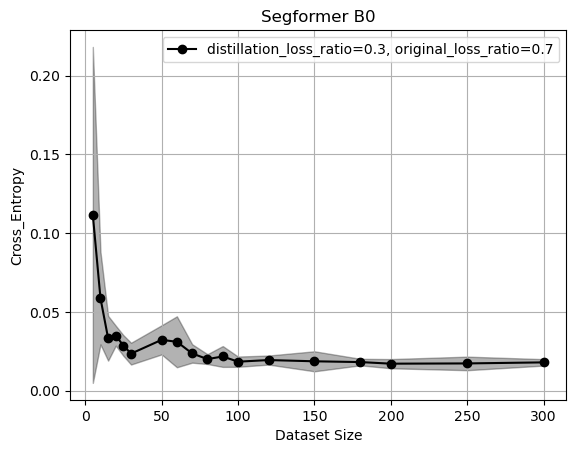

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()